# Setup

In [1]:
pwd # should be <your_root_dir>/f-dre/notebooks

'/atlas/u/madeline/f-dre/notebooks'

In [2]:
cd ..

/atlas/u/madeline/f-dre


In [3]:
import math
import sklearn.metrics.pairwise as sk
from sklearn.svm import SVC
from cvxopt import matrix, solvers
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.flows.models.maf import MAF
solvers.options['show_progress'] = False

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1) Dataset loading (run either (i) or (ii) -- not both)

## (i) EITHER: Load existing data from repo

In [14]:
train_data = np.load('data/uci_breast_cancer/train.npz')
X = train_data['x']
y = train_data['y']

test_data = np.load('data/uci_breast_cancer/test.npz')
Z = test_data['x']
u = test_data['y']

## (ii) OR: Generate new dataset
Reference: https://papers.nips.cc/paper/2006/file/a2186aa7c086b46ad4e8bf81e2a3a19b-Paper.pdf

If \\(s\\) is indicator variable representing whether or not a data point \\(x\\) is selected and \\(y\\) is its corresponding label, then \\(P(s = 1|y = 1) = 0.1 \ \ \text{and} \ \ P(s = 1|y = −1)\\) = 0.9.

In [13]:
# import pandas as pd
# import random
# from sklearn.model_selection import train_test_split

# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')
# # remove missing labels
# idxs_missing_labels = np.argwhere(np.array(df['1.3'] == '?')).flatten()
# df = df.drop(idxs_missing_labels).astype('int64')

# train_df, test_df = train_test_split(df, test_size=0.20)

# # attr key for malignant/benign
# attr = '2.1' 

# # construct biased source/domain splits; negative/positive labels are 2 and 4 in the original dataset.
# n_samples = len(df)
# p_group1 = 0.1
# p_group2 = 0.9

# group1_df = train_df.loc[train_df[attr] == 2]
# group2_df = train_df.loc[train_df[attr] == 4]

# group1_idxs = np.arange(len(group1_df))
# group2_idxs = np.arange(len(group2_df))
# group1_selected = np.array(np.nonzero(group1_idxs * (np.random.random(size=len(group1_idxs)) <= p_group1))[0])
# group2_selected = np.array(np.nonzero(group2_idxs * (np.random.random(size=len(group2_idxs)) <= p_group2))[0])
# group1_df = group1_df.iloc[group1_idxs[group1_selected]]
# group2_df = group2_df.iloc[group2_idxs[group2_selected]]

# biased_df = pd.concat((group1_df, group2_df))

# # standardize train data
# data = biased_df.to_numpy()[:, 1:10]
# X = (data - np.mean(data, axis=0))/np.std(data, axis=0)
# y = biased_df.to_numpy()[:, 10]
# # change labels to binary {0,1}
# y[y == 2] = 0
# y[y == 4] = 1

# # standardize test data
# data = test_df.to_numpy()[:, 1:10]
# Z = (data - np.mean(data, axis=0))/np.std(data, axis=0)
# u = test_df.to_numpy()[:, 10]
# # change labels to binary {0,1}
# u[u == 2] = 0
# u[u == 4] = 1

# 2) Load config

In [15]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [16]:
config_file = 'src/configs/flows/uci_breast_cancer/maf.yaml'
with open(config_file) as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

# 3) Load flow

In [17]:
def load_flow(restore_file):
    model = MAF(config.model.n_blocks, 
                config.model.input_size, 
                config.model.hidden_size, 
                config.model.n_hidden, 
                None, 
                config.model.activation_fn, 
                config.model.input_order, 
                batch_norm=True)
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cpu')
    model.load_state_dict(state['model_state'])
    model = model.to('cpu')
    model.eval()
    return model

In [51]:
device = 'cpu'
restore_dir = f'src/flows/results/uci_breast_cancer_maf'
flow = load_flow(restore_dir)

# 4) Define KMM function

In [19]:
def kmm(Xtrain, Xtest, sigma, B):
    n_tr = len(Xtrain)
    n_te = len(Xtest)

    # calculate kernel
    K_ns = sk.rbf_kernel(Xtrain, Xtrain, sigma)
    K = np.array(K_ns)
    
    # calculate kappa
    kappa_r = sk.rbf_kernel(Xtrain, Xtest, sigma)
    kappa = np.sum(np.array(kappa_r), axis=1)
    kappa = -(float(n_tr) / float(n_te)) * kappa

    # calculate eps
    eps = (math.sqrt(n_tr) - 1) / math.sqrt(n_tr)

    # constraints
    A0 = np.ones(shape=(1, n_tr))
    A1 = -np.ones(shape=(1, n_tr))
    A = np.vstack([A0, A1, -np.eye(n_tr), np.eye(n_tr)])
    b = np.array([[n_tr * (eps + 1), n_tr * (eps - 1)]])
    b = np.vstack([b.T, np.zeros(shape=(n_tr, 1)), np.ones(shape=(n_tr, 1)) * B])

    P = matrix(K, tc='d')
    q = matrix(kappa, tc='d')
    G = matrix(A, tc='d')
    h = matrix(b, tc='d')
    beta = solvers.qp(P, q, G, h)
    return [i for i in beta['x']]

# 5) Fit classifiers

In [31]:
# parameters to sweep over
svc_sigma = 0.1
Cs = [0.1, 1, 10, 100]
sigmas = [0.01, 0.1, 0.5, 1.0]
Bs = [1, 10, 100, 1000]

## Baseline classifier (unweighted)

In [25]:
baseline_errs = {}

for C in Cs:
    baseline_clf = SVC(C=C, gamma=svc_sigma)
    baseline_clf.fit(X, y)
    baseline_preds = baseline_clf.predict(Z)
    baseline_err = np.mean(baseline_preds != u, axis=0)
    baseline_errs[C] = baseline_err
for c in Cs:
    print(f'Baseline test error for C={c}: ', baseline_errs[c])

Baseline test error for C=0.1:  0.65234375
Baseline test error for C=1:  0.65234375
Baseline test error for C=10:  0.65234375
Baseline test error for C=100:  0.65234375


## X-DRE classifier (weighted)

In [36]:
best_x_errs = {}
best_x_kmm_sigmas = {}
best_x_Bs = {}
best_x_weights = {}
for C in Cs:
    best_x_kmm_sigma = 1
    best_x_B = 1
    best_x_err = float('inf')
    for kmm_sigma in sigmas:
        for B in Bs:
            x_dre_clf = SVC(C=C, gamma=svc_sigma)
            x_weights = kmm(X, Z, kmm_sigma, B)
            x_dre_clf.fit(X, y, sample_weight=x_weights)
            x_preds = x_dre_clf.predict(Z)
            x_err = np.mean(x_preds != u, axis=0)
            if x_err < best_x_err:
                best_x_err = x_err
                best_x_kmm_sigma= kmm_sigma
                best_x_B = B
                best_x_weight = x_weights
    best_x_weights[C] = best_x_weight
    best_x_errs[C] = best_x_err
    best_x_kmm_sigmas[C] = best_x_kmm_sigma
    best_x_Bs[C] = best_x_B
for c in Cs:
    print(f'Best x-dre test error for C={c}: ', best_x_errs[c])
    print('KMM sigma: ', best_x_kmm_sigmas[c])
    print('B: ', best_x_Bs[c])

Best x-dre test error for C=0.1:  0.65234375
KMM sigma:  0.01
B:  1
Best x-dre test error for C=1:  0.646484375
KMM sigma:  0.01
B:  10
Best x-dre test error for C=10:  0.65234375
KMM sigma:  0.01
B:  1
Best x-dre test error for C=100:  0.65234375
KMM sigma:  0.01
B:  1


## Z-DRE classifier (weighted)

In [39]:
best_z_errs = {}
best_z_kmm_sigmas = {}
best_z_Bs = {}
best_z_weights = {}


for C in Cs:
    best_z_kmm_sigma = 1
    best_z_B = 1
    best_z_err = float('inf')
    for kmm_sigma in sigmas:
        for B in Bs:
            z_dre_clf = SVC(C=C, gamma=svc_sigma)
            flow_X = flow.forward(torch.from_numpy(X).cpu().float())[0].detach().cpu().numpy().astype('float64')
            flow_Z = flow.forward(torch.from_numpy(Z).cpu().float())[0].detach().cpu().numpy().astype('float64')
            z_weights = kmm(flow_X, flow_Z, kmm_sigma, B)
            z_dre_clf.fit(X, y, sample_weight=z_weights)
            z_preds = z_dre_clf.predict(Z)
            z_err = np.mean(z_preds != u, axis=0)

            if z_err < best_z_err:
                best_z_err = z_err
                best_z_kmm_sigma= kmm_sigma
                best_z_B = B
                best_z_weight = z_weights
    best_z_weights[C] = best_z_weight
    best_z_errs[C] = best_z_err
    best_z_kmm_sigmas[C] = best_z_kmm_sigma
    best_z_Bs[C] = best_z_B
for c in Cs:
    print(f'Best z-dre test error for C={c}: ', best_z_errs[c])
    print('KMM sigma: ', best_z_kmm_sigmas[c])
    print('B: ', best_z_Bs[c])

Best z-dre test error for C=0.1:  0.65234375
KMM sigma:  0.01
B:  1
Best z-dre test error for C=1:  0.609375
KMM sigma:  0.01
B:  100
Best z-dre test error for C=10:  0.609375
KMM sigma:  0.01
B:  10
Best z-dre test error for C=100:  0.609375
KMM sigma:  0.01
B:  10


# 6) Plot results!

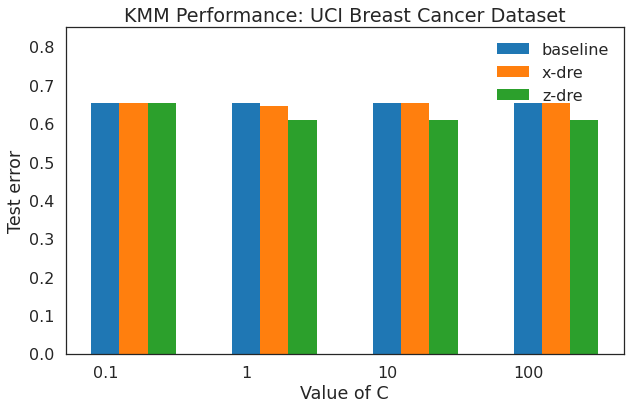

In [44]:
width = 0.2
plt.figure(figsize=(10,6))

for i, c in enumerate(Cs):
    labels = ['baseline', 'x-dre', 'z-dre'] if i == 0 else [None, None, None]
    plt.bar(i, baseline_errs[c],  width, label=labels[0], color=u'#1f77b4')
    plt.bar(i + width,  best_x_errs[c], width, label=labels[1], color=u'#ff7f0e')
    plt.bar(i + 2*width,  best_z_errs[c], width, label=labels[2], color=u'#2ca02c')

plt.xticks(np.arange(4), Cs)
plt.xlabel('Value of C')
plt.ylabel('Test error')
plt.ylim(0, 0.85)

plt.title('KMM Performance: UCI Breast Cancer Dataset')
plt.legend()
plt.show()